In [1]:
import sys
print(sys.executable)
print(sys.version)


C:\Users\snyder\Documents\Motor Logs\venv\Scripts\python.exe
3.13.12 (tags/v3.13.12:1cbe481, Feb  3 2026, 18:22:25) [MSC v.1944 64 bit (AMD64)]


In [2]:
from pathlib import Path
from bldc_loader import load_folder

LOGS = Path(r"C:\Users\snyder\Documents\Motor Logs\SD_dump")
rs = load_folder(LOGS)

len(rs.runs), rs.issues[:5]


(9, [])

In [3]:
r = rs.runs[0]
r.name, len(r.df), r.meta.get("derived", {}).get("fs_hz"), r.issues[:5]


('RUN0004',
 2327,
 50.0,
 ['json_invalid:Illegal trailing comma before end of object: line 7 column 24 (char 150)',
  'json_repaired_trailing_commas'])

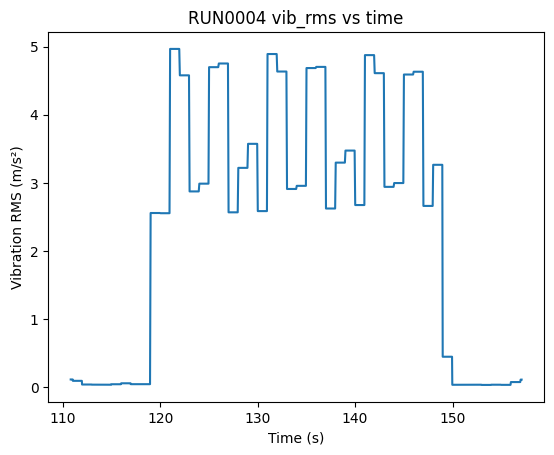

In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(r.df["time_s"], r.df["vib_rms_mps2"])
plt.xlabel("Time (s)")
plt.ylabel("Vibration RMS (m/s²)")
plt.title(f"{r.name} vib_rms vs time")
plt.show()


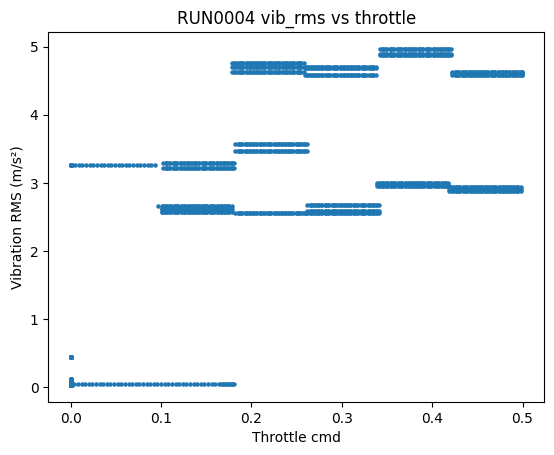

In [5]:
plt.figure()
plt.scatter(r.df["thr_cmd"], r.df["vib_rms_mps2"], s=5)
plt.xlabel("Throttle cmd")
plt.ylabel("Vibration RMS (m/s²)")
plt.title(f"{r.name} vib_rms vs throttle")
plt.show()


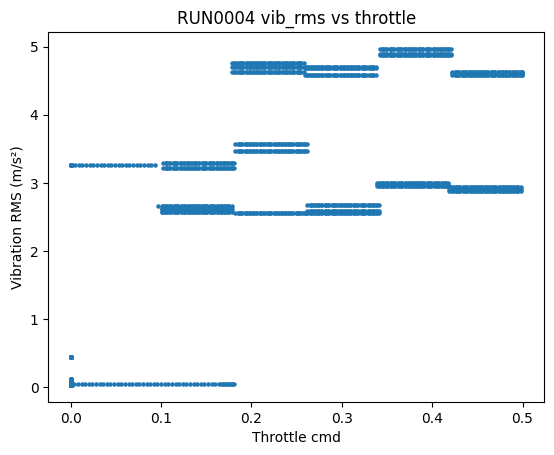

In [6]:
plt.figure()
plt.scatter(r.df["thr_cmd"], r.df["vib_rms_mps2"], s=5)
plt.xlabel("Throttle cmd")
plt.ylabel("Vibration RMS (m/s²)")
plt.title(f"{r.name} vib_rms vs throttle")
plt.show()


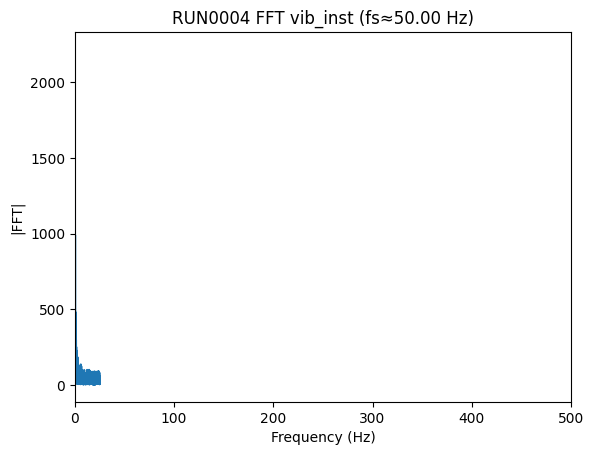

In [7]:
import numpy as np

sig = r.df["vib_inst_mps2"].dropna().to_numpy()
sig = sig - sig.mean()

fs = r.meta.get("derived", {}).get("fs_hz", 50.0)

yf = np.fft.rfft(sig)
xf = np.fft.rfftfreq(len(sig), d=1/fs)

plt.figure()
plt.plot(xf, np.abs(yf))
plt.xlim(0, 500)  # adjust as needed
plt.xlabel("Frequency (Hz)")
plt.ylabel("|FFT|")
plt.title(f"{r.name} FFT vib_inst (fs≈{fs:.2f} Hz)")
plt.show()


In [8]:
idx = r.df["vib_rms_mps2"].idxmax()
r.df.loc[idx, ["time_s","thr_cmd","esc_us","rpm","vib_rms_mps2"]]


time_s           121.004
thr_cmd            0.342
esc_us          1342.000
rpm               -1.000
vib_rms_mps2       4.967
Name: 520, dtype: float64

In [9]:
key_cols = ["time_s","thr_cmd","esc_us","vib_rms_mps2","vib_inst_mps2","rpm"]
missing = [c for c in key_cols if c not in r.df.columns]
missing


[]

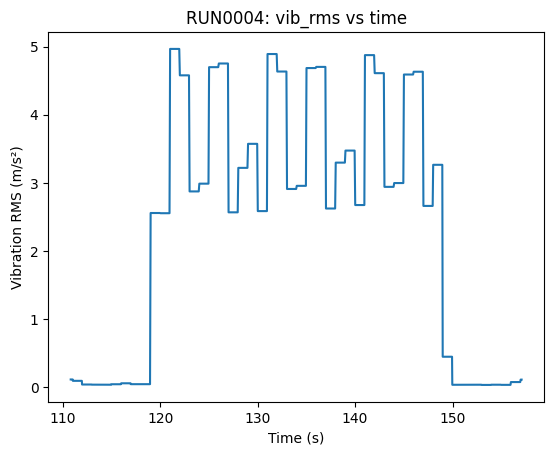

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(r.df["time_s"], r.df["vib_rms_mps2"])
plt.xlabel("Time (s)")
plt.ylabel("Vibration RMS (m/s²)")
plt.title(f"{r.name}: vib_rms vs time")
plt.show()


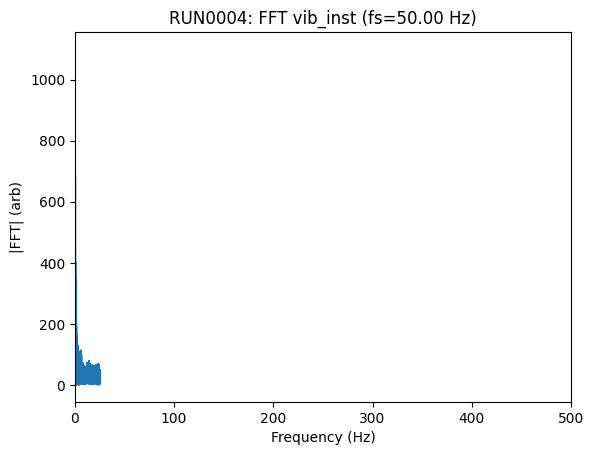

In [11]:
import numpy as np

sig = r.df["vib_inst_mps2"].dropna().to_numpy()
sig = sig - sig.mean()

fs = r.meta.get("derived", {}).get("fs_hz", 50.0)

# Hann window
w = np.hanning(len(sig))
yf = np.fft.rfft(sig * w)
xf = np.fft.rfftfreq(len(sig), d=1/fs)

plt.figure()
plt.plot(xf, np.abs(yf))
plt.xlim(0, 500)
plt.xlabel("Frequency (Hz)")
plt.ylabel("|FFT| (arb)")
plt.title(f"{r.name}: FFT vib_inst (fs={fs:.2f} Hz)")
plt.show()


In [12]:
import pandas as pd

rows = []
for run in rs.runs:
    df = run.df
    rows.append({
        "run": run.name,
        "n": len(df),
        "fs_hz": run.meta.get("derived", {}).get("fs_hz"),
        "vib_rms_max": df["vib_rms_mps2"].max() if "vib_rms_mps2" in df.columns else None,
        "vib_rms_mean": df["vib_rms_mps2"].mean() if "vib_rms_mps2" in df.columns else None,
        "thr_at_max": df.loc[df["vib_rms_mps2"].idxmax(), "thr_cmd"] if "thr_cmd" in df.columns else None,
        "issues": ";".join(run.issues),
    })

summary_df = pd.DataFrame(rows).sort_values("vib_rms_max", ascending=False)
summary_df


,run,n,fs_hz,vib_rms_max,vib_rms_mean,thr_at_max,issues
8,RUN0012,709,50.0,12.498,4.845850,0.727,"json_invalid:Expecting ',' delimiter: line 38 ..."
7,RUN0011,509,50.0,11.651,4.913175,0.731,"json_invalid:Expecting ',' delimiter: line 38 ..."
6,RUN0010,1036,50.0,5.575,3.218512,0.440,"json_invalid:Expecting ',' delimiter: line 38 ..."
2,RUN0006,1536,50.0,5.540,3.696611,0.418,json_invalid:Illegal trailing comma before end...
1,RUN0005,1535,50.0,5.480,3.406083,0.387,json_invalid:Illegal trailing comma before end...
0,RUN0004,2327,50.0,4.967,2.374504,0.342,json_invalid:Illegal trailing comma before end...
4,RUN0008,457,50.0,4.819,3.459873,0.498,"json_invalid:Expecting ',' delimiter: line 38 ..."
5,RUN0009,434,50.0,3.549,2.755806,0.199,"json_invalid:Expecting ',' delimiter: line 38 ..."
3,RUN0007,636,50.0,3.228,2.793653,0.238,"json_invalid:Expecting ',' delimiter: line 38 ..."
